<a href="https://colab.research.google.com/github/31SUFI/EDA-on-smart-energy-Meter/blob/main/EDA_smart_energy_meter_with_ML_models_to_predict_and_detect_anamolies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook presents an Exploratory Data Analysis (EDA) and Machine Learning study on smart energy consumption data collected from a household.  
The goal is to analyze power usage **before** and **after** installing an IoT-driven smart energy meter and to demonstrate the impact of the meter on reducing energy consumption.

We will:

- Load and inspect the datasets representing power usage over 30 days.
- Explore data quality, missing values, and summary statistics.
- Visualize energy consumption patterns by room, appliance, and over time.
- Build a machine learning regression model to predict power usage based on appliance and time features.
- Implement an anomaly detection model to identify unusual power consumption events.

This project simulates a real-world IoT energy monitoring system and highlights the potential for energy savings through smart devices and data-driven insights.


# **1. Dataset Loading & Overview**

In this section, we load our energy usage datasets representing power consumption **before** and **after** applying the smart energy meter.  
We will check the shape, column types, and a quick snapshot of the data.


In [1]:
from google.colab import files

# Upload both CSVs
uploaded = files.upload()



Saving after_meter.csv to after_meter.csv
Saving before_meter.csv to before_meter.csv


# **2. Basic Data Exploration**

Here, we explore the dataset's structure, check for missing values, and calculate summary statistics such as mean, median, max, and standard deviation of power usage.  
This helps us understand the general power consumption patterns and the impact of the energy meter.


In [19]:
import pandas as pd

# Load the datasets
before_df = pd.read_csv("before_meter.csv")
after_df = pd.read_csv("after_meter.csv")

# Display the first few rows
before_df.head()
after_df.head()

,timestamp,room,appliance,power_usage_watts,status
0,2025-04-01 00:00:00,Living Room,TV,106.18,ON
1,2025-04-01 00:00:00,Living Room,Fan,0.00,OFF
2,2025-04-01 00:00:00,Living Room,Light,28.22,ON
3,2025-04-01 00:00:00,Bedroom,AC,1332.45,ON
4,2025-04-01 00:00:00,Bedroom,Fan,65.82,ON


In [3]:
before_df['timestamp'] = pd.to_datetime(before_df['timestamp'])
after_df['timestamp'] = pd.to_datetime(after_df['timestamp'])


# **3. Power Usage Summary Table**

We create a concise summary table comparing power consumption statistics before and after the meter installation.  
This comparison highlights the reduction in average and peak power usage.


In [6]:
# Summary stats for both datasets
before_stats = {
    'Mean': before_df['power_usage_watts'].mean(),
    'Median': before_df['power_usage_watts'].median(),
    'Max': before_df['power_usage_watts'].max(),
    'Std Dev': before_df['power_usage_watts'].std()
}

after_stats = {
    'Mean': after_df['power_usage_watts'].mean(),
    'Median': after_df['power_usage_watts'].median(),
    'Max': after_df['power_usage_watts'].max(),
    'Std Dev': after_df['power_usage_watts'].std()
}

# Convert to DataFrame
summary_df = pd.DataFrame([before_stats, after_stats], index=['Before Meter', 'After Meter'])

# Round values to 2 decimal places
summary_df = summary_df.round(2)

# Display nicely
print("📊 Power Usage Summary (in Watts):")
summary_df


📊 Power Usage Summary (in Watts):


,Mean,Median,Max,Std Dev
Before Meter,328.96,42.39,2199.96,603.88
After Meter,259.78,34.24,1799.71,479.13


In [7]:
print("Missing values (Before):\n", before_df.isnull().sum())
print("\nMissing values (After):\n", after_df.isnull().sum())


Missing values (Before):
 timestamp            0
room                 0
appliance            0
power_usage_watts    0
status               0
dtype: int64

Missing values (After):
 timestamp            0
room                 0
appliance            0
power_usage_watts    0
status               0
dtype: int64


# **4. Exploratory Data Visualization**

Next, we visualize the power consumption trends over time and compare usage across different rooms and appliances.  
These visualizations provide intuitive insights into energy usage behavior.


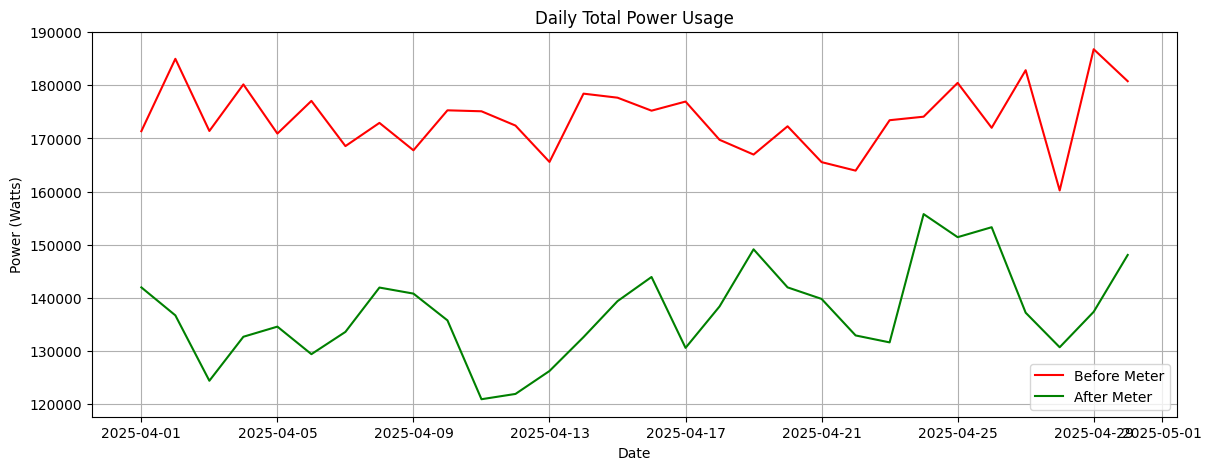

In [8]:
# Resample by day and sum power
before_daily = before_df.resample('D', on='timestamp').sum()
after_daily = after_df.resample('D', on='timestamp').sum()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(before_daily.index, before_daily['power_usage_watts'], label='Before Meter', color='red')
plt.plot(after_daily.index, after_daily['power_usage_watts'], label='After Meter', color='green')
plt.title('Daily Total Power Usage')
plt.ylabel('Power (Watts)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


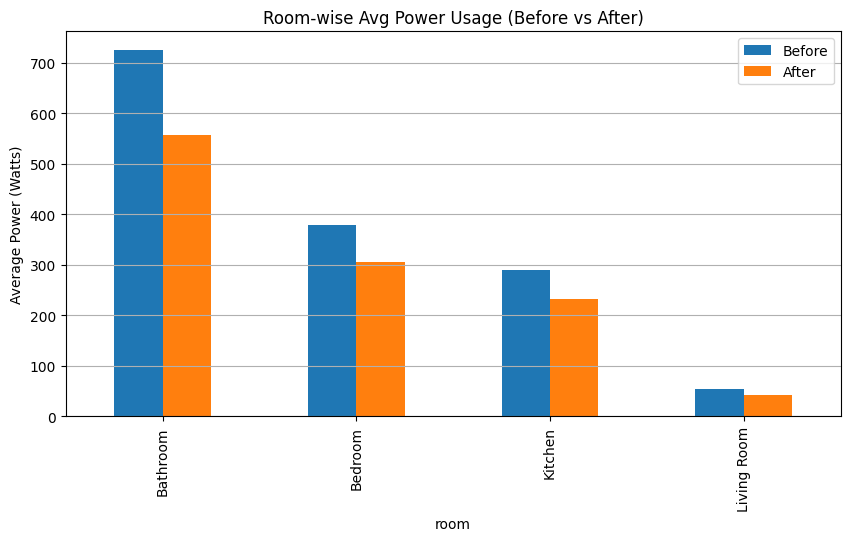

In [9]:
# Group by room
room_comparison = pd.DataFrame({
    'Before': before_df.groupby('room')['power_usage_watts'].mean(),
    'After': after_df.groupby('room')['power_usage_watts'].mean()
})

room_comparison.plot(kind='bar', figsize=(10, 5), title="Room-wise Avg Power Usage (Before vs After)")
plt.ylabel('Average Power (Watts)')
plt.grid(axis='y')
plt.show()


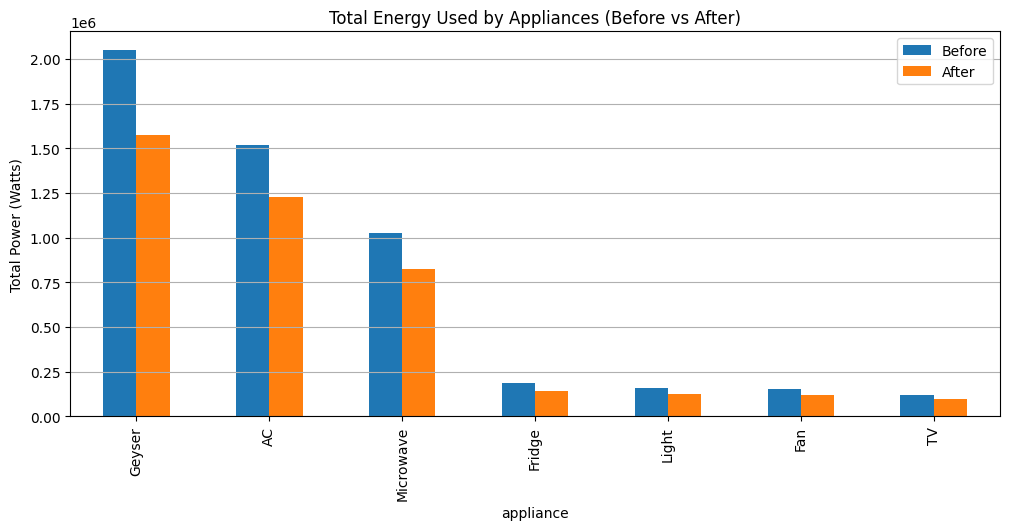

In [10]:
# Top appliances consuming energy
appliance_usage = pd.DataFrame({
    'Before': before_df.groupby('appliance')['power_usage_watts'].sum(),
    'After': after_df.groupby('appliance')['power_usage_watts'].sum()
}).sort_values(by='Before', ascending=False)

appliance_usage.plot(kind='bar', figsize=(12, 5), title='Total Energy Used by Appliances (Before vs After)')
plt.ylabel('Total Power (Watts)')
plt.grid(axis='y')
plt.show()


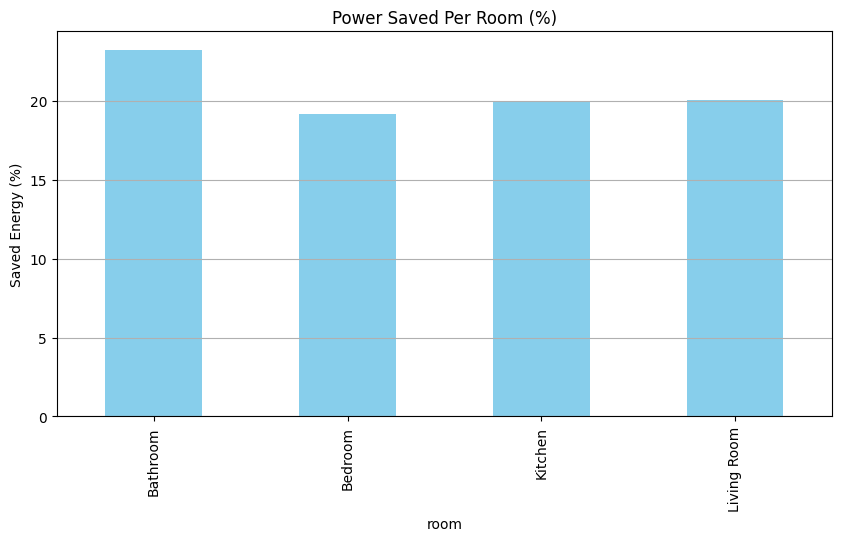

In [11]:
room_comparison['Saved (%)'] = ((room_comparison['Before'] - room_comparison['After']) / room_comparison['Before']) * 100
room_comparison['Saved (%)'].plot(kind='bar', color='skyblue', figsize=(10, 5), title='Power Saved Per Room (%)')
plt.ylabel('Saved Energy (%)')
plt.grid(axis='y')
plt.show()


In [12]:
total_before = before_df['power_usage_watts'].sum()
total_after = after_df['power_usage_watts'].sum()
savings = ((total_before - total_after) / total_before) * 100

print(f"Total Power Before Meter: {total_before:.2f} watts")
print(f"Total Power After Meter: {total_after:.2f} watts")
print(f"Total Energy Saved: {savings:.2f}%")


Total Power Before Meter: 5210736.20 watts
Total Power After Meter: 4114949.92 watts
Total Energy Saved: 21.03%


# **5. Machine Learning: Predicting Power Usage**

We build a Random Forest regression model to predict power consumption based on time, room, appliance, and status.  
This model helps us forecast energy demand and optimize appliance usage.


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Use the 'after' dataset (you can also use 'before' similarly)
df = after_df.copy()

# Extract datetime features from timestamp
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Drop timestamp (we extracted features) and status will be encoded later
X = df[['room', 'appliance', 'status', 'hour', 'dayofweek']]
y = df['power_usage_watts']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['room', 'appliance', 'status'])

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Training samples: 12672, Test samples: 3168


In [14]:
# Initialize model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [15]:
# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} Watts")
print(f"R^2 Score: {r2:.2f}")


RMSE: 44.22 Watts
R^2 Score: 0.99


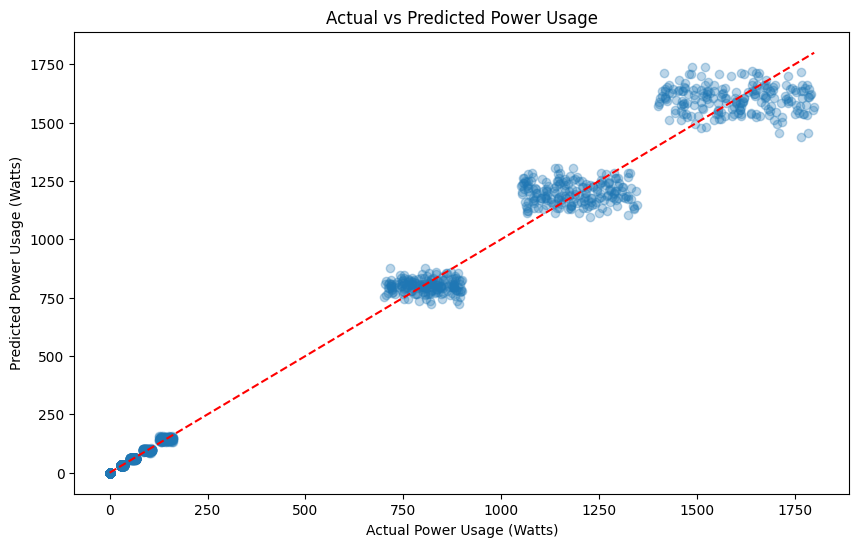

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Power Usage (Watts)")
plt.ylabel("Predicted Power Usage (Watts)")
plt.title("Actual vs Predicted Power Usage")
plt.show()


# **6. Anomaly Detection in Power Usage**

To detect unusual power consumption patterns, we use Isolation Forest, an unsupervised machine learning algorithm.  
This helps identify potential faults or energy waste by highlighting anomalies.


In [17]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

# Use the 'after' dataset as example
df_anomaly = after_df.copy()

# Extract time features
df_anomaly['hour'] = df_anomaly['timestamp'].dt.hour
df_anomaly['dayofweek'] = df_anomaly['timestamp'].dt.dayofweek

# Use numeric features for anomaly detection
features = df_anomaly[['power_usage_watts', 'hour', 'dayofweek']]

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # assuming ~1% anomalies

# Fit the model
iso_forest.fit(features)

# Predict anomalies (-1 = anomaly, 1 = normal)
df_anomaly['anomaly'] = iso_forest.predict(features)

# Count anomalies detected
anomaly_count = (df_anomaly['anomaly'] == -1).sum()
print(f"Anomalies detected: {anomaly_count}")


Anomalies detected: 159


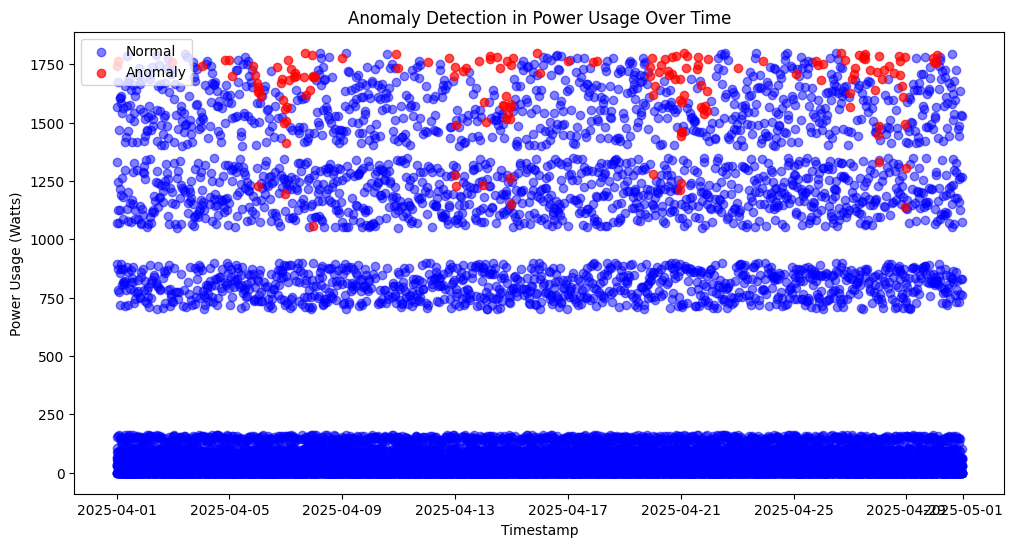

In [18]:
plt.figure(figsize=(12,6))
normal = df_anomaly[df_anomaly['anomaly'] == 1]
anomalies = df_anomaly[df_anomaly['anomaly'] == -1]

plt.scatter(normal['timestamp'], normal['power_usage_watts'], c='blue', label='Normal', alpha=0.5)
plt.scatter(anomalies['timestamp'], anomalies['power_usage_watts'], c='red', label='Anomaly', alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('Power Usage (Watts)')
plt.title('Anomaly Detection in Power Usage Over Time')
plt.legend()
plt.show()
